###  Deep Learning Object Detection Model for Bird species Classification

Image data processing is one of the most under-explored problems in the data science community.For training deep learning models, we requires a lot of data. Here I chose the bird species : Periparus Ater, Erithacus Rubecula and Pica pica to detect species of birds using Convolutional Neural Network (CNN) architectures. The dataset consists of a total of 2400 images, with 800 images per class for three bird species. The images are annotated  and TFRecords are generated by combining the images and XML files. These TFRecords are then used for training the models.

 The models chosen for training are Faster R-CNN and SSD ResNet50. Faster R-CNN is a powerful state-of-the-art model known for its high performance and accuracy in object detection tasks. However, due to its complexity, it exhibits slower detection speeds in real-time applications and video scenarios. On the other hand, SSD ResNet50 is a faster model that sacrifices some accuracy for quicker inference times.

 For both the models I will check the evaluation metrics and choose the better model for deployment and inferencing.



##  Data Preprocessing

In [16]:
# Import required packages
import os
import seaborn as sns
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import shutil
%matplotlib inline

### Resolution distribution of images

The resolution distribution of images in the dataset is analyzed by calculating the dimensions (width and height) of the image files.
To analyze the resolution distribution of these images, the 'dim1' and 'dim2' arrays are  used. Using a plotting library such as Matplotlib, a histogram or density plot can be generated to visualize the distribution of image resolutions based on the dimensions stored in the arrays. This allows for a better understanding of the variation in image sizes within the dataset.

Let's see the resolution distribution of the image dataset in order to select the right model for training.




In [5]:
# To store image properties created dim1 and dim2 arrays
dim1 = []
dim2 = []
for image_filename in os.listdir('./images'):
    name, ext = os.path.splitext(image_filename)
    try:
        if not ext == '.xml':
            img = imread('./images/'+image_filename)
            d1,d2,color = img.shape
            dim1.append(d1)
            dim2.append(d2)            
    except: 
        print(image_filename)
        continue

test
cleaned
train


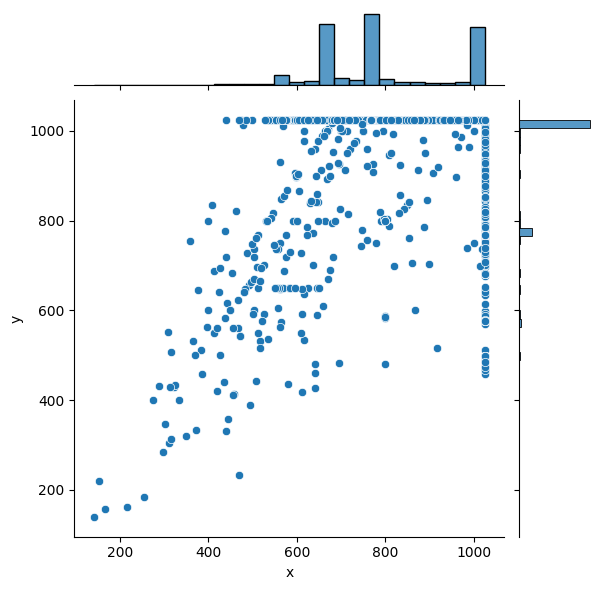

In [6]:
# create a dataframe using these two variables
df=pd.DataFrame({'x':dim1,'y':dim2})
# Now we can have a jointplot leveraging the
# sns.jointplot() and passing in the x and y columns 
# of the newly created dataframe
sns.jointplot(x = "x", y = "y",
              kind = "scatter", data = df)
# show the plot
plt.show()


we got a 2D plot, where each dot(in the scatter plot) corresponds to one row/data item of the dataframe. It also reflects two histograms one at the top which denotes the distribution with respect to the attribute on the x-axis that tells us how the data is located as we vary x; the other histogram is located on the y-axis towards the right of the scatter plot which tells the data distribution with respect to the respective attribute on the y-axis.


It's clear from the grpah that the resolution of most images lies in the range of 1000 through x and y axis. It would be better to choose the model that has been pre-trained on 1024 x 1024 images. Tensorflow Object Detection API has models trained on many different resolutions.


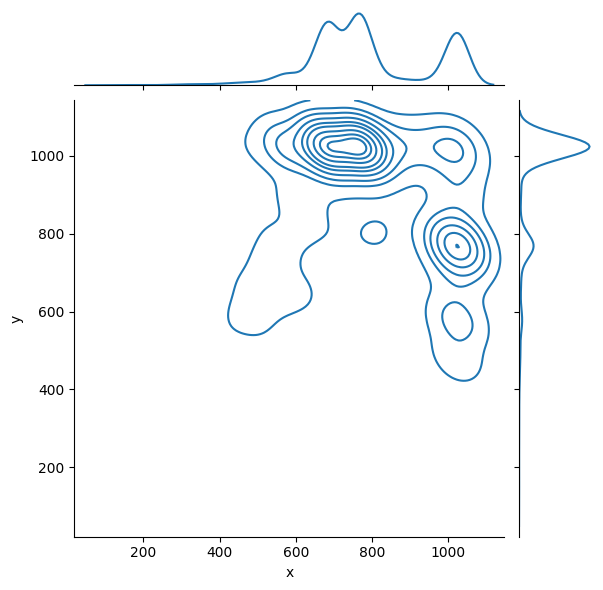

In [7]:
sns.jointplot(x = "x", y = "y",
              kind = "kde", data = df)
# show the plot
plt.show()

Instead of showing the histograms, it depicts a smooth curve/plot, and further, the scatter plot is replaced by a shaded contour plot, the darker the color the denser the region.

In [9]:
np.mean(dim1)

789.0445193929173

In [10]:
print('Min:', np.min(dim1))
print('Max:', np.max(dim1))

Min: 142
Max: 1024


In [11]:
np.mean(dim2)

941.0543001686341

In [12]:
print('Min:', np.min(dim2))
print('Max:', np.max(dim2))

Min: 140
Max: 1024


### Removing Bad images and xml files

During the data tagging process, it was observed that several images either lacked the desired object or were of low quality. To address this, a decision was made to label these images as "BadImages" to indicate their unsuitability. However, it is crucial to remove these files from the dataset before creating TFRecords to ensure data integrity.

The provided function aims to extract values from XML files and organize them into a dataframe. This process involves parsing the XML file to retrieve relevant information and structuring it in a tabular format. The resulting dataframe facilitates further analysis and processing of the tagged data, enabling efficient data handling and model training.

In [14]:
# function to extract values from xml files and creating a dataframe with those values
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     float(root.find('size')[0].text),
                     float(root.find('size')[1].text),
                     member[0].text,
                     float(member[4][0].text),
                     float(member[4][2].text),
                     float(member[4][1].text),
                     float(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

The XML files are converted into a dataframe for further analysis, specifically to identify the filenames associated with "BadImages" values. This process involves parsing the XML files and organizing the extracted information into a structured dataframe format. By analyzing the dataframe, the filenames corresponding to the "BadImages" values can be identified. This information is crucial for the subsequent step of deleting the image and XML files associated with these "BadImages" instances, ensuring the removal of undesired or low-quality data from the dataset.

In [17]:
image_path = os.path.join(os.getcwd(), 'images/')
print(image_path)
xml_df = xml_to_csv(image_path)

/home/msc1/Desktop/cw2-reff/Tensorflow-Object-Detection-API/Base/v1/object_detection/images/


In [18]:
xml_df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,pica_pica978.jpg,1024.0,768.0,Pica_pica,497.951463,325.670633,620.556878,482.758821
1,periparus_ater_337.jpg,1024.0,683.0,Periparus_ater,232.595749,221.478979,458.617887,355.502157
2,ErithacusRubecula0060.jpg,1024.0,678.0,Erithacus_Rubecula,558.226472,242.407109,710.435587,432.950372
3,periparus_ater_3.jpg,1024.0,768.0,Periparus_ater,323.703667,318.164131,486.154153,435.659766
4,periparus_ater_469.jpg,1024.0,795.0,Periparus_ater,386.406278,281.594346,822.679208,542.036065


In [42]:


xml_df.loc[xml_df['filename'] == 'LoxodontaAfricana086.jpg', 'filename'] = 'Periparus_ater0021'

# Print the updated DataFrame


In [28]:
xml_df['class'].unique()


array(['Pica_pica', 'Periparus_ater', 'Erithacus_Rubecula', 'Bad_image'],
      dtype=object)

In [43]:
xml_df.loc[xml_df['class'] == 'Bad_image']


,filename,width,height,class,xmin,ymin,xmax,ymax
50,pica_pica,1024.0,680.0,Bad_image,403.443122,44.101232,940.573507,660.387673
65,pica_pica23,1024.0,768.0,Bad_image,506.891441,223.499454,796.802162,623.244193
66,pica_pica23,1024.0,768.0,Bad_image,140.352336,134.099673,629.496856,620.689913
400,pica_pica0923,1024.0,766.0,Bad_image,385.892428,485.323079,603.714598,622.894975
401,pica_pica0923,1024.0,766.0,Bad_image,413.916333,442.013407,542.571533,501.882659
...,...,...,...,...,...,...,...,...
2908,pica_pica0911,680.0,1024.0,Bad_image,196.960349,621.541340,276.994440,752.661020
3031,Periparus_ater0911,1024.0,768.0,Bad_image,171.003690,278.416463,472.408668,716.475394
3035,Periparus_ater0851,1024.0,683.0,Bad_image,228.052591,111.307385,870.909526,647.400094
3144,Periparus_ater0021,1024.0,685.0,Bad_image,35.849712,192.510523,256.838123,403.246895


Upon observation, it is evident that there are 117 rows in the dataset with "Bad_image" values, corresponding to an equal number of XML files. In order to extract the filenames associated with these "Bad_image" values and generate a list of such filenames, the following approach can be employed:

In [48]:
# dataframe containing only NoGood values
bad_image_df = xml_df.loc[xml_df['class'] == 'Bad_image']
# creating a list of filenames
bad_image_list = list(bad_image_df['filename'])


### Script to delete BadImage images and XML files

Below script will delete the xml and jpg images which belongs to Bad_image

In [49]:
# loop through the filename list
for file in bad_image_list:
    # check if file exists
    if os.path.isfile(image_path + file):
        os.remove(image_path + file)
        os.remove(image_path + file.replace('jpg', 'xml'))
    else:
        print(f"Error: {file} file not found")

Now let's create a new dataframe using xml_to_csv function 


In [54]:
new_df = xml_to_csv(image_path)


Check the unique classes of the 'class' column of the new dataframe



In [58]:
new_df['class'].unique()


array(['Pica_pica', 'Periparus_ater', 'Erithacus_Rubecula'], dtype=object)

There  is no entry for Bad_image

In [57]:
new_df.loc[new_df['class'] == 'Bad_image']

,filename,width,height,class,xmin,ymin,xmax,ymax


From the output , it's clear that all of the bad images are deleted from the dataset